# NYC Vehicle Crashes

## Data Sources
#### Bike Stations - https://feeds.citibikenyc.com/stations/stations.json
#### Vehicle Crashes - https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-CollisionsCrashes/h9gi-nx95

### Loading Packages

In [18]:
#import libraries
import calendar
import datetime
import requests
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import itertools
import matplotlib.dates as mdates
from matplotlib import cm
import seaborn as sns
#from pywaffle import Waffle
import geopandas as gpd #import shape file 
from geopy.distance import geodesic 
plt.style.use('ggplot')
sns.set_style('darkgrid')
sns.set_palette(palette='vlag')
from osgeo import gdal
from pyproj import Proj, transform
#import folium
from folium.plugins import HeatMap
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

#plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [19]:
#Set the Working Directory of the Project
os.chdir('C:\\Users\\136247\\Desktop\\NYC')

<IPython.core.display.Javascript object>

## Importing data For Vehicles Crashes

In [20]:
#bike_stations = pd.read_json('https://feeds.citibikenyc.com/stations/stations.json')
vehicle_crashes = pd.read_csv('.\Motor_Vehicle_Collisions_-_Crashes.csv', low_memory=False)

In [21]:
vehicle_crashes.shape

(1760597, 29)

In [22]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [152]:
#vehicle_crashes.columns.to_list()
vehicle_crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1760597 entries, 0 to 1760596
Data columns (total 23 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   crash_date                     datetime64[ns]
 1   crash_time                     object        
 2   borough                        object        
 3   zip_code                       object        
 4   latitude                       float64       
 5   longitude                      float64       
 6   location                       object        
 7   on_street_name                 object        
 8   cross_street_name              object        
 9   number_of_persons_injured      float64       
 10  number_of_persons_killed       float64       
 11  number_of_pedestrians_injured  int64         
 12  number_of_pedestrians_killed   int64         
 13  number_of_cyclist_injured      int64         
 14  number_of_cyclist_killed       int64         
 15  number_of_motor

In [24]:
# % Of Missing Values in the file
pd.DataFrame(vehicle_crashes.isnull().sum() / vehicle_crashes.shape[0] *100, columns=['Missing Value %'])

Missing Value %
CRASH DATE                            0.000000
CRASH TIME                            0.000000
BOROUGH                              30.711742
ZIP CODE                             30.723726
LATITUDE                             11.850980
LONGITUDE                            11.850980
LOCATION                             11.850980
ON STREET NAME                       20.148450
CROSS STREET NAME                    35.144329
OFF STREET NAME                      85.097953
NUMBER OF PERSONS INJURED             0.001022
NUMBER OF PERSONS KILLED              0.001761
NUMBER OF PEDESTRIANS INJURED         0.000000
NUMBER OF PEDESTRIANS KILLED          0.000000
NUMBER OF CYCLIST INJURED             0.000000
NUMBER OF CYCLIST KILLED              0.000000
NUMBER OF MOTORIST INJURED            0.000000
NUMBER OF MOTORIST KILLED             0.000000
CONTRIBUTING FACTOR VEHICLE 1         0.281211
CONTRIBUTING FACTOR VEHICLE 2        14.148780
CONTRIBUTING FACTOR VEHICLE 3        93.304089
CONTRIBUTING FACTOR VEHICLE 4        98.560488
CONTRIBUTING FACTOR VEHICLE 5        99.623934
COLLISION_ID                          0.000000
VEHICLE TYPE CODE 1                   0.525958
VEHICLE TYPE CODE 2                  16.528598
VEHICLE TYPE CODE 3                  93.485278
VEHICLE TYPE CODE 4                  98.600929
VEHICLE TYPE CODE 5                  99.633817

<AxesSubplot:title={'center':'HEATMAP OF MISSING VALUES'}>

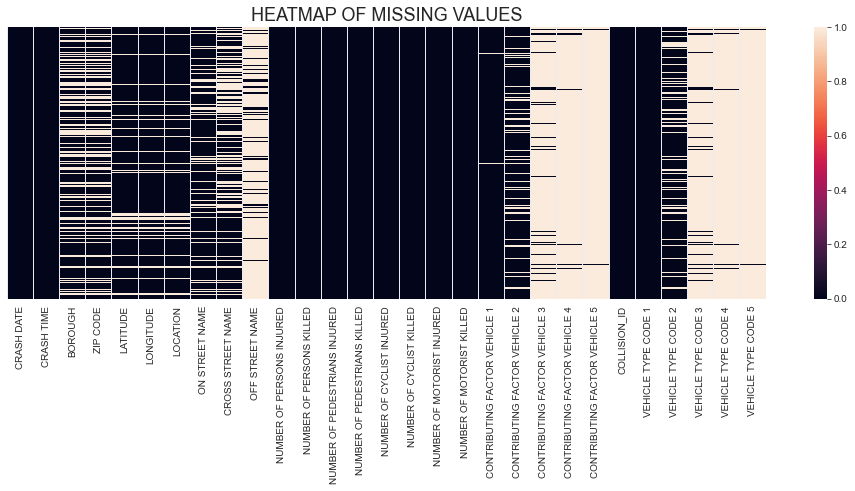

In [25]:
#Visualization of the missing values
plt.figure(figsize=(17,5))
plt.title('HEATMAP OF MISSING VALUES', fontsize=18)
sns.heatmap(vehicle_crashes.isnull(), yticklabels=False)

## Data Pre-processing and Cleaning

Drop all the columns with more than 85% na data    
Fill the missing Zip code with the Lat and long uszipcode library
Fill the missing Borough data from the Zip Code 

In [26]:
#Dropping the Columns with more than 85% missing Data
limitPer = len(vehicle_crashes) * .15
vehicle_crashes = vehicle_crashes.dropna(thresh=limitPer, axis=1)

In [27]:
#replace capslock to lowercase
vehicle_crashes.columns = map(str.lower, vehicle_crashes.columns)
vehicle_crashes.columns = vehicle_crashes.columns.str.replace(" ", "_")

#convert date and time to datetime object 
vehicle_crashes['datetime'] = pd.to_datetime(vehicle_crashes['crash_date'] + ' ' + vehicle_crashes['crash_time'])

#set date  and time type to datetime64
vehicle_crashes.crash_date = vehicle_crashes.crash_date.astype("datetime64")
vehicle_crashes['crash_time'] = pd.to_datetime(vehicle_crashes['crash_time']).dt.time

In [28]:
print('End Date of Crashes: ',max(vehicle_crashes.datetime))
print('Start Date of Crashes: ',min(vehicle_crashes.datetime))

End Date of Crashes:  2021-03-06 23:50:00
Start Date of Crashes:  2012-07-01 00:05:00


<AxesSubplot:title={'center':'HEATMAP OF MISSING VALUES'}>

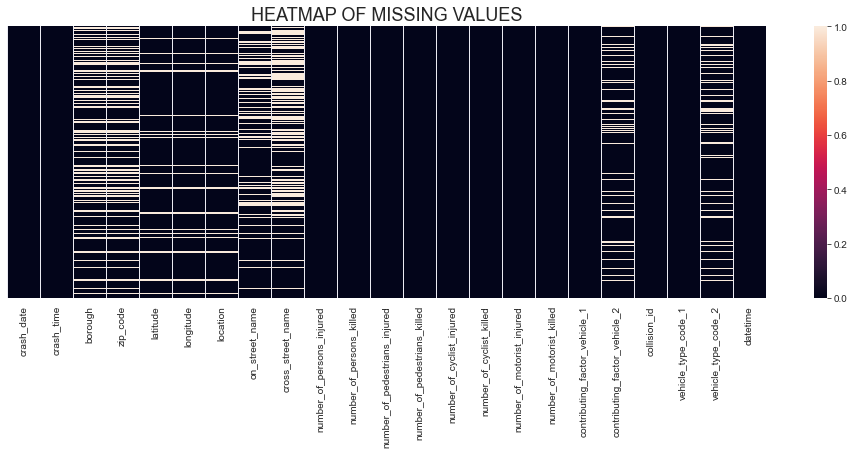

In [29]:
plt.figure(figsize=(17,5))
plt.title('HEATMAP OF MISSING VALUES', fontsize=18)
sns.heatmap(vehicle_crashes.isnull(), yticklabels=False)

In [30]:
vehicle_crashes.isna().sum()

crash_date                            0
crash_time                            0
borough                          540710
zip_code                         540921
latitude                         208648
longitude                        208648
location                         208648
on_street_name                   354733
cross_street_name                618750
number_of_persons_injured            18
number_of_persons_killed             31
number_of_pedestrians_injured         0
number_of_pedestrians_killed          0
number_of_cyclist_injured             0
number_of_cyclist_killed              0
number_of_motorist_injured            0
number_of_motorist_killed             0
contributing_factor_vehicle_1      4951
contributing_factor_vehicle_2    249103
collision_id                          0
vehicle_type_code_1                9260
vehicle_type_code_2              291002
datetime                              0
dtype: int64

### Fixing the Misisng Zipcode and Borough Information

In [31]:
zipcode = pd.read_csv('.\\us-zip-code-latitude-and-longitude.csv',sep=';')
zipcode_ny = zipcode.loc[zipcode['State']=='NY']
zipcode_bor = pd.read_csv('.\\Zip_borough.csv')
zipcode_ny = pd.merge(zipcode_ny, zipcode_bor, how='right')

In [32]:
vehicle_crash = vehicle_crashes[vehicle_crashes['latitude'].notna() & vehicle_crashes['longitude'].notna()]
print(vehicle_crash.shape)
vehicle_crash = vehicle_crash[vehicle_crash['zip_code'].isna()]
print(vehicle_crash.shape)
vehicle_crash = vehicle_crash[(vehicle_crash[['latitude','longitude']] != 0).all(axis=1)]
print(vehicle_crash.shape)

(1551949, 23)
(363824, 23)
(363528, 23)


In [33]:
# % of Missing Values in the Files
pd.DataFrame(vehicle_crash.isnull().sum() / vehicle_crash.shape[0] *100, columns=['Missing Value %'])

Missing Value %
crash_date                            0.000000
crash_time                            0.000000
borough                              99.946634
zip_code                            100.000000
latitude                              0.000000
longitude                             0.000000
location                              0.000000
on_street_name                       20.675711
cross_street_name                    86.133118
number_of_persons_injured             0.001375
number_of_persons_killed              0.001375
number_of_pedestrians_injured         0.000000
number_of_pedestrians_killed          0.000000
number_of_cyclist_injured             0.000000
number_of_cyclist_killed              0.000000
number_of_motorist_injured            0.000000
number_of_motorist_killed             0.000000
contributing_factor_vehicle_1         0.218140
contributing_factor_vehicle_2        12.681554
collision_id                          0.000000
vehicle_type_code_1                   0.516054
vehicle_type_code_2                  16.392960
datetime                              0.000000

In [34]:
#Fill the ZIP code from the Latitude and Longitude data set with 363528 missing zip Codes
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)
from uszipcode import Zipcode

def get_zipcode(lat, lon):
    result = search.by_coordinates(lat = lat, lng = lon, returns = 1)
    print(result[0].zipcode)
    return result[0].zipcode

In [35]:
# Fixing the first 10 Zip Codes. The same can be done for the entire data set 
vehicle_crash['zip_code']=(vehicle_crash.head(5).apply(lambda x: get_zipcode(x.latitude,x.longitude), axis=1))

10314
11103
11226
10455
11368


In [36]:
# The first 5 Zip Codes have been updated. 
vehicle_crash.head(10)

crash_date crash_time borough zip_code   latitude  longitude  \
2  2018-10-15   07:05:00     NaN    10314  40.594310 -74.143190   
3  2018-10-26   16:00:00     NaN    11103  40.756256 -73.924515   
5  2018-10-26   22:15:00     NaN    11226  40.652490 -73.952670   
11 2018-10-16   00:20:00     NaN    10455  40.804226 -73.913010   
12 2018-10-19   20:40:00     NaN    11368  40.738907 -73.847560   
13 2018-10-05   07:10:00     NaN      NaN  40.610508 -74.095760   
15 2018-10-10   19:40:00     NaN      NaN  40.684887 -74.001110   
23 2018-10-25   14:34:00     NaN      NaN  40.845190 -73.911200   
29 2018-10-12   13:10:00     NaN      NaN  40.729553 -73.911880   
32 2018-10-05   21:00:00     NaN      NaN  40.829327 -73.847410   

                   location                    on_street_name  \
2     (40.59431, -74.14319)  FOREST HILL ROAD                   
3   (40.756256, -73.924515)  35 AVENUE                          
5     (40.65249, -73.95267)  LINDEN BOULEVARD                   
11   (40.804226, -73.91301)  BRUCKNER EXPRESSWAY                
12   (40.738907, -73.84756)  LONG ISLAND EXPRESSWAY             
13   (40.610508, -74.09576)  STATEN ISLAND EXPRESSWAY           
15   (40.684887, -74.00111)  BROOKLYN QUEENS EXPRESSWAY         
23     (40.84519, -73.9112)  CROSS BRONX EXPY                   
29   (40.729553, -73.91188)  58 STREET                          
32   (40.829327, -73.84741)  CROSS BRONX EXPY                   

   cross_street_name  number_of_persons_injured  ...  \
2       FIELD STREET                        0.0  ...   
3                NaN                        0.0  ...   
5                NaN                        0.0  ...   
11               NaN                        0.0  ...   
12               NaN                        0.0  ...   
13               NaN                        0.0  ...   
15               NaN                        0.0  ...   
23               NaN                        0.0  ...   
29     BORDEN AVENUE                        0.0  ...   
32               NaN                        0.0  ...   

    number_of_cyclist_injured  number_of_cyclist_killed  \
2                           0                         0   
3                           0                         0   
5                           0                         0   
11                          0                         0   
12                          0                         0   
13                          0                         0   
15                          0                         0   
23                          0                         0   
29                          0                         0   
32                          0                         0   

    number_of_motorist_injured  number_of_motorist_killed  \
2                            0                          0   
3                            0                          0   
5                            0                          0   
11                           0                          0   
12                           0                          0   
13                           0                          0   
15                           0                          0   
23                           0                          0   
29                           0                          0   
32                           0                          0   

     contributing_factor_vehicle_1   contributing_factor_vehicle_2  \
2   Driver Inattention/Distraction  Driver Inattention/Distraction   
3   Driver Inattention/Distraction                     Unspecified   
5                      Unspecified                             NaN   
11                     Unspecified                             NaN   
12            Unsafe Lane Changing                     Unspecified   
13           Following Too Closely                     Unspecified   
15  Driver Inattention/Distraction                     Unspecified   
23                     Unspecified                

In [37]:
#search.by_coordinates(lat = 40.734337, lng = -74.002396, returns = 1)

In [38]:
vehicle_crashes.columns

Index(['crash_date', 'crash_time', 'borough', 'zip_code', 'latitude',
       'longitude', 'location', 'on_street_name', 'cross_street_name',
       'number_of_persons_injured', 'number_of_persons_killed',
       'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
       'number_of_cyclist_injured', 'number_of_cyclist_killed',
       'number_of_motorist_injured', 'number_of_motorist_killed',
       'contributing_factor_vehicle_1', 'contributing_factor_vehicle_2',
       'collision_id', 'vehicle_type_code_1', 'vehicle_type_code_2',
       'datetime'],
      dtype='object')

In [39]:
#vehicle_crashes.groupby('borough')['number_of_persons_killed'].sum().sort_values(ascending = False)
vehicle_crashes.pivot_table(values=['number_of_persons_killed','number_of_persons_injured','number_of_cyclist_injured','number_of_cyclist_killed'],index='borough',columns=None,aggfunc='sum').reset_index().sort_values('number_of_persons_injured',ascending=False)

borough  number_of_cyclist_injured  number_of_cyclist_killed  \
1       BROOKLYN                      12535                        52   
3         QUEENS                       6259                        27   
2      MANHATTAN                       9215                        29   
0          BRONX                       3267                        13   
4  STATEN ISLAND                        356                         3   

   number_of_persons_injured  number_of_persons_killed  
1                   113627.0                     463.0  
3                    87853.0                     419.0  
2                    51502.0                     252.0  
0                    51242.0                     184.0  
4                    13313.0                      76.0

### Borough-wise Analysis

In [40]:
borough_wise = vehicle_crashes.groupby(['borough']).size().reset_index(name='NoOfAccidents')
borough_wise.head()

borough  NoOfAccidents
0          BRONX         175014
1       BROOKLYN         382270
2      MANHATTAN         284174
3         QUEENS         326701
4  STATEN ISLAND          51728

In [41]:
# Import the ShapeFile for Borough Boundaries
fp = 'Borough Boundaries/geo_export_87071461-9196-46f3-8d1b-52fed88fb835.shp'
borough_geo = gpd.read_file(fp)

borough_geo['boro_name'] = borough_geo['boro_name'].str.upper() 

# Merging ShapeFile with data
borough_wise = borough_geo.set_index('boro_name').join(borough_wise.set_index('borough'))
borough_geo

boro_code      boro_name    shape_area     shape_leng  \
0        2.0          BRONX  1.186612e+09  462958.187332   
1        5.0  STATEN ISLAND  1.623756e+09  325960.628294   
2        3.0       BROOKLYN  1.937593e+09  738745.840717   
3        4.0         QUEENS  3.045878e+09  904188.424111   
4        1.0      MANHATTAN  6.366027e+08  361212.476577   

                                            geometry  
0  MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...  
1  MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...  
2  MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ...  
3  MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ...  
4  MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...

In [42]:
borough_geo['coords'] = borough_geo['geometry'].apply(lambda x: x.representative_point().coords[:])
borough_geo['coords'] = [coords[0] for coords in borough_geo['coords']]
borough_geo

boro_code      boro_name    shape_area     shape_leng  \
0        2.0          BRONX  1.186612e+09  462958.187332   
1        5.0  STATEN ISLAND  1.623756e+09  325960.628294   
2        3.0       BROOKLYN  1.937593e+09  738745.840717   
3        4.0         QUEENS  3.045878e+09  904188.424111   
4        1.0      MANHATTAN  6.366027e+08  361212.476577   

                                            geometry  \
0  MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...   
1  MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...   
2  MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ...   
3  MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ...   
4  MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...   

                                     coords  
0   (-73.86633177719249, 40.85607244148029)  
1  (-74.14564248821605, 40.572490738411084)  
2   (-73.94864366802588, 40.65433337705035)  
3   (-73.82063009855042, 40.70496927540509)  
4  (-73.96025111098584, 40.788708666396616)

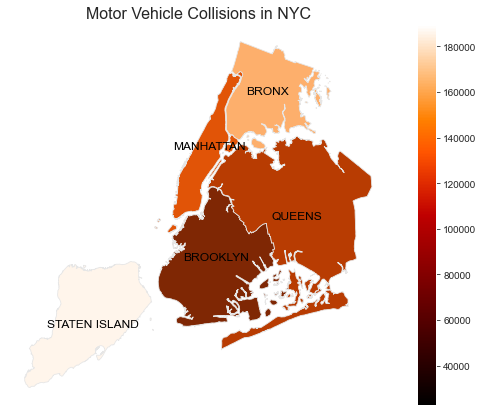

In [43]:
#Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 7))

# Drawing the Map
borough_wise.plot(column = 'NoOfAccidents', cmap = 'Oranges', linewidth = 0.8, ax = ax, edgecolor = '0.9')

# Map customizations
ax.axis('off')
ax.set_title('Motor Vehicle Collisions in NYC', size = 16)
for idx, row in borough_geo.iterrows():
    ax.annotate(text=row['boro_name'], xy=row['coords'], horizontalalignment = 'center', verticalalignment = 'center', fontsize = 12, color = '#000000')

# Adding a color bar legend to the map
sm = plt.cm.ScalarMappable(cmap = 'gist_heat', norm = plt.Normalize(vmin = 22822, vmax = 189648))
cbar = fig.colorbar(sm)


####  Brooklyn and Queens have reported a very high number of accidents. On the other hand, Staten Island reported the least number of accidents in New York City boroughs.

# 1. What is the most dangerous NYC borough / area for a bicycle rider? Use visualization. 
## BROOKLYN and MANHATTAN 

#### ROAD ACCIDENTS ARE MORE FREQUENT IN BROOKLYN AND MANHATTAN 
#### STATEN ISLAND HAS THE LOWEST ACCIDENT RATE

borough
BROOKLYN         12535
MANHATTAN         9215
QUEENS            6259
BRONX             3267
STATEN ISLAND      356
Name: number_of_cyclist_injured, dtype: int64
borough
BROOKLYN         52
MANHATTAN        29
QUEENS           27
BRONX            13
STATEN ISLAND     3
Name: number_of_cyclist_killed, dtype: int64


<AxesSubplot:title={'center':'Cyclist Killed Per Borough'}, xlabel='borough', ylabel='number_of_cyclist_killed'>

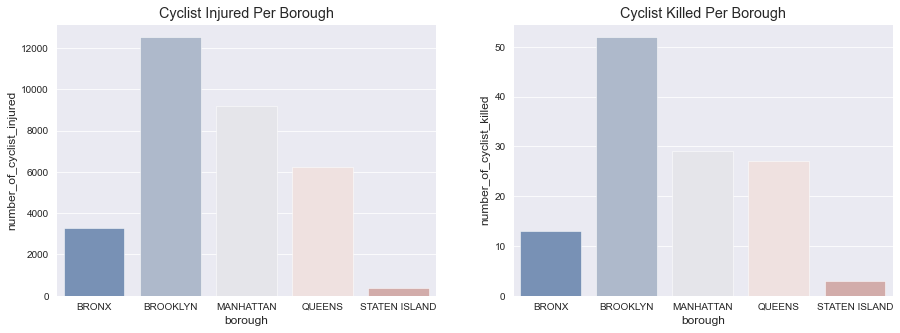

In [44]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
print(vehicle_crashes.groupby('borough')['number_of_cyclist_injured'].sum().sort_values(ascending=False))
plt.title('Cyclist Injured Per Borough')
sns.barplot(x=vehicle_crashes.groupby('borough').size().index,
            y=vehicle_crashes.groupby('borough')['number_of_cyclist_injured'].sum())
plt.subplot(1,2,2)
print(vehicle_crashes.groupby('borough')['number_of_cyclist_killed'].sum().sort_values(ascending=False))
plt.title('Cyclist Killed Per Borough')
sns.barplot(x=vehicle_crashes.groupby('borough').size().index,
            y=vehicle_crashes.groupby('borough')['number_of_cyclist_killed'].sum())

#### CYCLISTS ARE MORE PRONE TO INJURY AND DEADTH IN BRONX and BROOKLYN BOROUGH

<AxesSubplot:xlabel='borough', ylabel='number_of_persons_killed'>

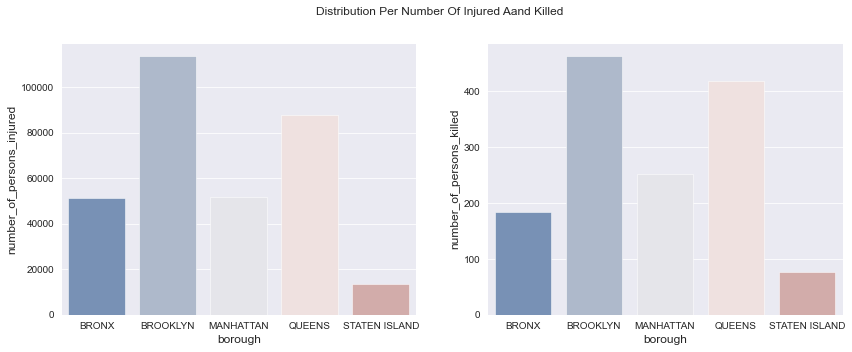

In [45]:
accidents_df = vehicle_crashes.groupby('borough')[['number_of_persons_injured', 'number_of_persons_killed']].sum()
fig, ax = plt.subplots(1,2,figsize=(14,5))
plt.suptitle('Distribution Per Number Of Injured Aand Killed')
sns.barplot(x=accidents_df.index, y=accidents_df['number_of_persons_injured'], data=accidents_df, ax=ax[0])
sns.barplot(x=accidents_df.index, y=accidents_df['number_of_persons_killed'], data=accidents_df, ax=ax[1])

<AxesSubplot:title={'center':'KILLED PERCENTAGE'}, xlabel='borough'>

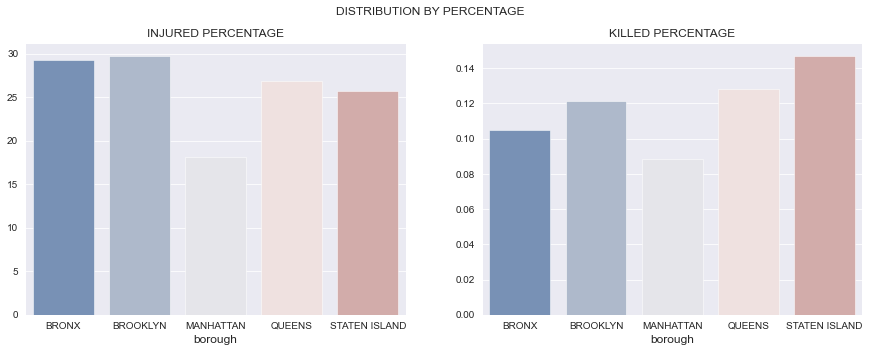

In [46]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
plt.suptitle('DISTRIBUTION BY PERCENTAGE')

ax[0].set_title('INJURED PERCENTAGE', fontsize=12)
ax[1].set_title('KILLED PERCENTAGE', fontsize=12)

sns.barplot(x= (accidents_df['number_of_persons_injured'] / vehicle_crashes.groupby('borough').size() *100).index, 
            y= (accidents_df['number_of_persons_injured'] / vehicle_crashes.groupby('borough').size() *100).values, ax=ax[0])

sns.barplot(x= (accidents_df['number_of_persons_killed'] / vehicle_crashes.groupby('borough').size() *100).index, 
            y= (accidents_df['number_of_persons_killed'] / vehicle_crashes.groupby('borough').size() *100).values, ax=ax[1] )

In [47]:
print('MEAN INJURED: ',(accidents_df['number_of_persons_injured'] / vehicle_crashes.groupby('borough').size() *100).values.mean().round(2))
print('MEAN KILLED: ',(accidents_df['number_of_persons_killed'] / vehicle_crashes.groupby('borough').size() *100).values.mean().round(2))

#There is a 25% chance that you will get injured if you get into an road accident except Manhattan.
#Probability of getting killed on an accident is very low.

MEAN INJURED:  25.95
MEAN KILLED:  0.12


In [48]:
datewise = vehicle_crashes.groupby(['crash_date', 'borough'])[[i for i in vehicle_crashes.columns if 'number' in i]].sum()

In [49]:
#len(vehicle_crashes.crash_date.unique())
datewise

number_of_persons_injured  number_of_persons_killed  \
crash_date borough                                                              
2012-07-01 BRONX                               11.0                       0.0   
           BROOKLYN                            47.0                       0.0   
           MANHATTAN                           36.0                       0.0   
           QUEENS                              26.0                       0.0   
           STATEN ISLAND                        8.0                       0.0   
...                                             ...                       ...   
2021-03-06 BRONX                               11.0                       0.0   
           BROOKLYN                            19.0                       0.0   
           MANHATTAN                            6.0                       0.0   
           QUEENS                               8.0                       0.0   
           STATEN ISLAND                        0.0                       0.0   

                          number_of_pedestrians_injured  \
crash_date borough                                        
2012-07-01 BRONX                                      1   
           BROOKLYN                                  11   
           MANHATTAN                                 15   
           QUEENS                                     3   
           STATEN ISLAND                              0   
...                                                 ...   
2021-03-06 BRONX                                      2   
           BROOKLYN                                   3   
           MANHATTAN                                  0   
           QUEENS                                     0   
           STATEN ISLAND                              0   

                          number_of_pedestrians_killed  \
crash_date borough                                       
2012-07-01 BRONX                                     0   
           BROOKLYN                                  0   
           MANHATTAN                                 0   
           QUEENS                                    0   
           STATEN ISLAND                             0   
...                                                ...   
2021-03-06 BRONX                                     0   
           BROOKLYN                                  0   
           MANHATTAN                                 0   
           QUEENS                                    0   
           STATEN ISLAND                             0   

                          number_of_cyclist_injured  number_of_cyclist_killed  \
crash_date borough                                                              
2012-07-01 BRONX                                  2                         0   
           BROOKLYN                               4                         0   
           MANHATTAN                              3                         0   
           QUEENS                                 0                         0   
           STATEN ISLAND                          0                         0   
...                                             ...                       ...   
2021-03-06 BRONX                                  0                         0   
           BROOKLYN                               0                         0   
           MANHATTAN                              3                         0   
           QUEENS                                 0                         0   
           STATEN ISLAND                          0                         0   

                          number_of_motorist_injured  \
crash_date borough                                     
2012-07-01 BRONX                                   8   
           BROOKLYN                               32   
           MANHATTAN                              18   
           QUEENS                                 23   
           STATEN ISLAND                           8   
...

In [50]:
injuries_and_fatalities = vehicle_crashes.groupby(['borough'])\
['number_of_persons_killed', 'number_of_persons_injured'].agg('sum').reset_index()

injuries_and_fatalities['Total Accidents'] = vehicle_crashes.groupby(['borough']).size().\
reset_index(name='NoOfAccidents').NoOfAccidents

# Injuries and Fatalities as Percentages
injuries_and_fatalities['Injury%'] = round((injuries_and_fatalities['number_of_persons_injured']\
/ injuries_and_fatalities['Total Accidents'] * 100), 1)
injuries_and_fatalities['Fatality%'] = round((injuries_and_fatalities['number_of_persons_killed']\
/ injuries_and_fatalities['Total Accidents'] * 100), 3)

injuries_and_fatalities.head()

borough  number_of_persons_killed  number_of_persons_injured  \
0          BRONX                     184.0                    51242.0   
1       BROOKLYN                     463.0                   113627.0   
2      MANHATTAN                     252.0                    51502.0   
3         QUEENS                     419.0                    87853.0   
4  STATEN ISLAND                      76.0                    13313.0   

   Total Accidents  Injury%  Fatality%  
0           175014     29.3      0.105  
1           382270     29.7      0.121  
2           284174     18.1      0.089  
3           326701     26.9      0.128  
4            51728     25.7      0.147

In [51]:
# Dropping redudant column and merging with ShapeFile
injuries_and_fatalities.drop('Total Accidents', axis = 1, inplace = True)
injuries_and_fatalities = borough_geo.set_index('boro_name').join(injuries_and_fatalities.set_index('borough'))

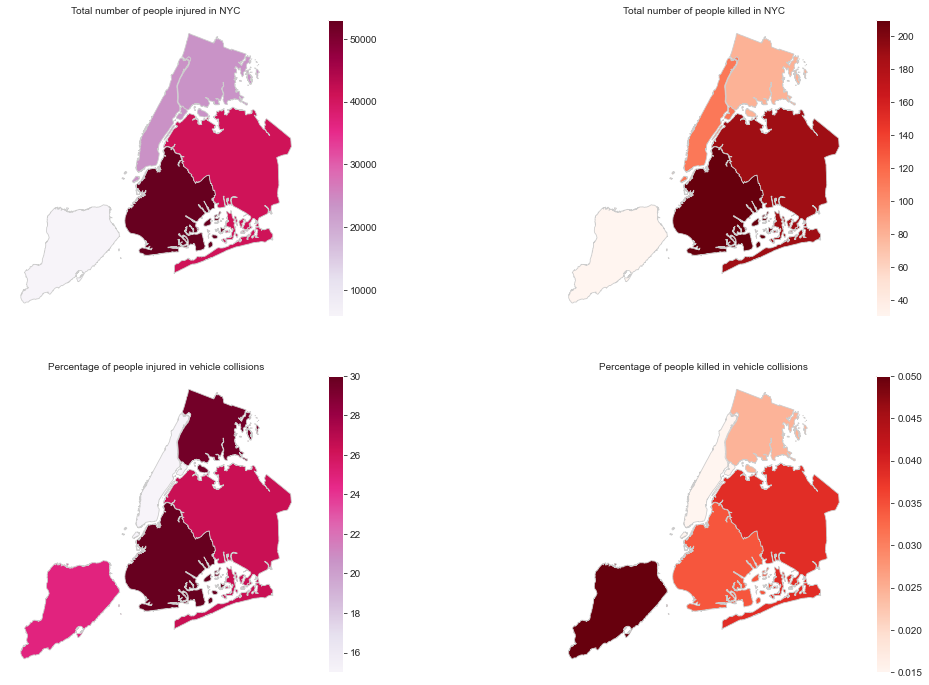

In [52]:
# Create figure and axes for Matplotlib
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(18, 12))

# Drawing the maps
injuries_and_fatalities.plot(column = 'number_of_persons_injured', cmap = 'PuRd', linewidth = 0.8, 
                      ax = ax1, edgecolor = '0.8')
injuries_and_fatalities.plot(column = 'number_of_persons_killed', cmap = 'Reds', linewidth = 0.8, 
                      ax = ax2, edgecolor = '0.8')
injuries_and_fatalities.plot(column = 'Injury%', cmap = 'PuRd', linewidth = 0.8, 
                      ax = ax3, edgecolor = '0.8')
injuries_and_fatalities.plot(column = 'Fatality%', cmap = 'Reds', linewidth = 0.8, 
                      ax = ax4, edgecolor = '0.8')

# Map customizations
ax1.axis('off'); ax2.axis('off'); ax3.axis('off'); ax4.axis('off')
ax1.set_title('Total number of people injured in NYC', size = 10)
ax2.set_title('Total number of people killed in NYC', size = 10)
ax3.set_title('Percentage of people injured in vehicle collisions', size = 10)
ax4.set_title('Percentage of people killed in vehicle collisions', size = 10)

# Adding color bar legends to the maps
sm = plt.cm.ScalarMappable(cmap = 'PuRd', norm = plt.Normalize(vmin = 5800, vmax = 53000))
cbar = fig.colorbar(sm, ax = ax1)

sm = plt.cm.ScalarMappable(cmap = 'Reds', norm = plt.Normalize(vmin = 30, vmax = 210))
cbar = fig.colorbar(sm, ax = ax2)

sm = plt.cm.ScalarMappable(cmap = 'PuRd', norm = plt.Normalize(vmin = 15, vmax = 30))
cbar = fig.colorbar(sm, ax = ax3)

sm = plt.cm.ScalarMappable(cmap = 'Reds', norm = plt.Normalize(vmin = 0.05, vmax = 0.015))
cbar = fig.colorbar(sm, ax = ax4)


In [54]:
#plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [55]:
fig = make_subplots(subplot_titles=('NUMBER OF PERSONS KILLED PER DAY',' '))
#fig = make_subplots(rows=2,cols=1, subplot_titles=('NUMBER OF INJURED PER DAY', 'NUMBER OF KILLED PER DAY'))
cols = ['QUEENS', 'BROOKLYN', 'MANHATTAN', 'BRONX', 'STATEN ISLAND']
feat  = [i for i in vehicle_crashes.columns if 'number' in i] + ['crash_date']

for i, bor in enumerate(cols):
    data_per_bor = vehicle_crashes[vehicle_crashes['borough']== bor][feat]
    data_per_bor = data_per_bor.groupby('crash_date').sum()
    
    #fig.add_trace(go.Scatter(x=data_per_bor.index, y=data_per_bor['number_of_persons_injured'], name=bor), row=1,col=1)
    fig.add_trace(go.Scatter(x=data_per_bor.index, y=data_per_bor['number_of_persons_killed'], name=bor))

fig.update_layout(template='plotly_dark', width=1000, height=600)
fig.show()

In [56]:
vehicle_crashes.groupby('crash_date').size().mean()

555.2182276884264

#### The highest number of people killed per day on a car accident is 8 on october 2017
#### There are approximately 555 road accident in a day.

In [57]:
weekwise = vehicle_crashes.copy()

def week_of_month(tgtdate):
    days_this_month = calendar.mdays[tgtdate.month]
    for i in range(1, days_this_month):
        d = datetime.datetime(tgtdate.year, tgtdate.month, i)
        if d.day - d.weekday() > 0:
            startdate = d
            break
    # now we canuse the modulo 7 appraoch
    return (tgtdate - startdate).days //7 + 1

weekwise['weekofmonth'] = weekwise['crash_date'].apply(lambda d: (d.day-1) // 7 + 1)
weekwise['weekofyear'] = weekwise['crash_date'].dt.weekofyear
weekwise['month'] = weekwise['crash_date'].dt.month
weekwise['year'] = weekwise['crash_date'].dt.year

<AxesSubplot:title={'center':'KILLED'}, xlabel='weekofmonth', ylabel='number_of_persons_killed'>

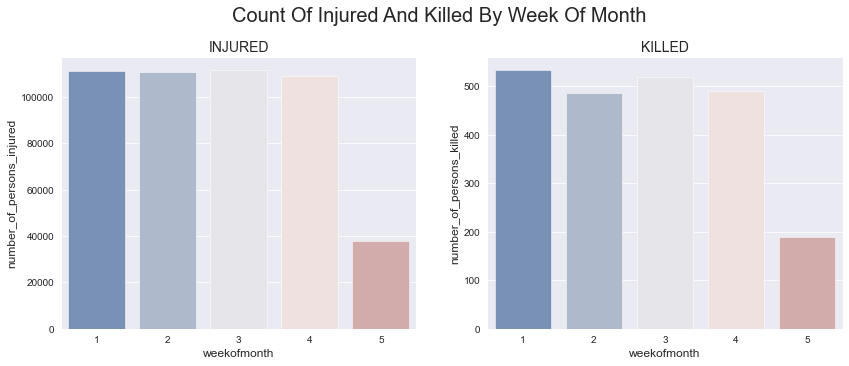

In [58]:
weekwise_month = weekwise.groupby('weekofmonth')[[i for i in weekwise.columns if 'number' in i]].sum()

fig,ax = plt.subplots(1,2,figsize=(14,5))
plt.suptitle('Count Of Injured And Killed By Week Of Month', x=0.5, y=1.02, fontsize=20)
ax[0].set_title('INJURED', fontsize=14)
ax[1].set_title('KILLED', fontsize=14)


sns.barplot(x=weekwise_month['number_of_persons_injured'].index ,y=weekwise_month['number_of_persons_injured'], ax=ax[0])
sns.barplot(x=weekwise_month['number_of_persons_killed'].index ,y=weekwise_month['number_of_persons_killed'], ax=ax[1])

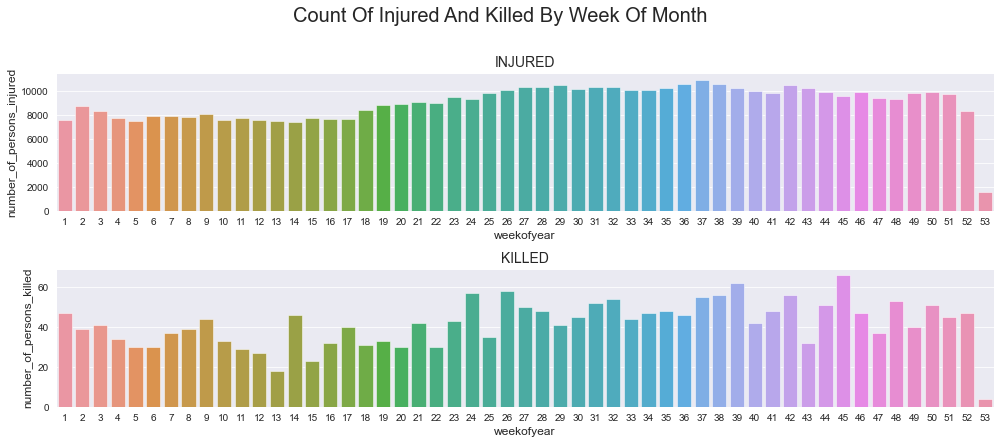

In [59]:
weekwise_year = weekwise.groupby('weekofyear')[[i for i in weekwise.columns if 'number' in i]].sum()

fig,ax = plt.subplots(2,1,figsize=(14,6))
plt.suptitle('Count Of Injured And Killed By Week Of Month', x=0.5, y=1.02, fontsize=20)
ax[0].set_title('INJURED', fontsize=14)
sns.barplot(x=weekwise_year['number_of_persons_injured'].index ,y=weekwise_year['number_of_persons_injured'], ax=ax[0])

ax[1].set_title('KILLED', fontsize=14)
sns.barplot(x=weekwise_year['number_of_persons_killed'].index ,y=weekwise_year['number_of_persons_killed'], ax=ax[1])
plt.tight_layout()

<AxesSubplot:title={'center':'KILLED'}, xlabel='month', ylabel='number_of_persons_killed'>

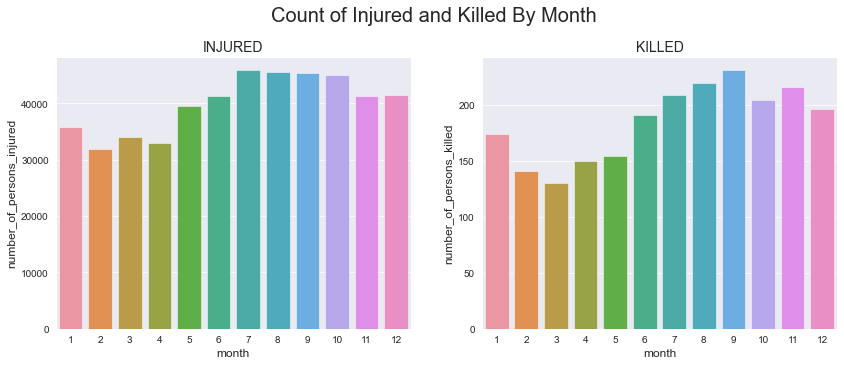

In [60]:
by_month = weekwise.groupby('month')[[i for i in weekwise.columns if 'number' in i]].sum()

fig,ax = plt.subplots(1,2,figsize=(14,5))
plt.suptitle('Count of Injured and Killed By Month', x=0.5, y=1.02, fontsize=20)
ax[0].set_title('INJURED', fontsize=14)
ax[1].set_title('KILLED', fontsize=14)


sns.barplot(x=by_month['number_of_persons_injured'].index ,y=by_month['number_of_persons_injured'], ax=ax[0])
sns.barplot(x=by_month['number_of_persons_killed'].index ,y=by_month['number_of_persons_killed'], ax=ax[1])

<AxesSubplot:title={'center':'KILLED'}, xlabel='year', ylabel='number_of_persons_killed'>

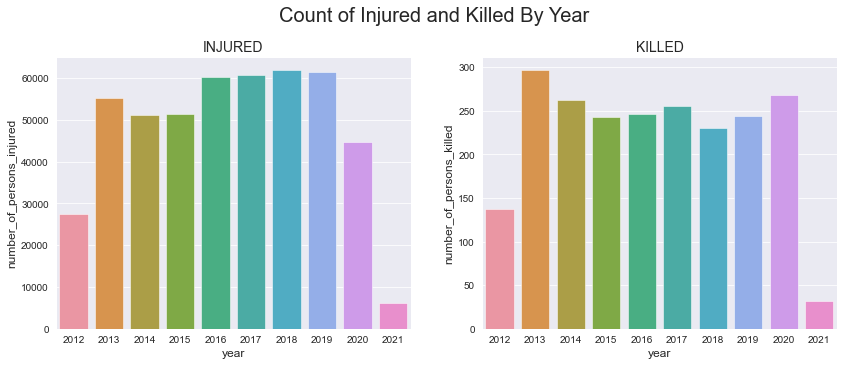

In [61]:
by_year = weekwise.groupby('year')[[i for i in weekwise.columns if 'number' in i]].sum()
# remove 2021 and 2012 and plot the mean of the accidents 
fig,ax = plt.subplots(1,2,figsize=(14,5))
plt.suptitle('Count of Injured and Killed By Year', x=0.5, y=1.02, fontsize=20)
ax[0].set_title('INJURED', fontsize=14)
ax[1].set_title('KILLED', fontsize=14)


sns.barplot(x=by_year['number_of_persons_injured'].index ,y=by_year['number_of_persons_injured'], ax=ax[0])
sns.barplot(x=by_year['number_of_persons_killed'].index ,y=by_year['number_of_persons_killed'], ax=ax[1])

In [62]:
per_day_val = round(vehicle_crashes.shape[0]/vehicle_crashes.groupby('crash_date')['number_of_persons_injured'].count().shape[0],2)
per_week_val = round(per_day_val * 7, 2)
per_month_val = round(per_day_val * 30, 2)
per_year_val = per_month_val * 12
per_hour_val = (per_day_val / 24)
per_5mins_val = (per_day_val / 24) /60  * 5

index = ['5mins', 'Hour', 'Day', 'Week', 'Month', 'Year']
data = [per_5mins_val, per_hour_val, per_day_val, per_week_val, per_month_val, per_year_val]
pd.DataFrame(index=index, data=data, columns=['Value']).T.round()


5mins  Hour    Day    Week    Month      Year
Value    2.0  23.0  555.0  3887.0  16657.0  199879.0

#### According to data above, There are approximately:
#### 199,879 Road Accidents per year
#### 16,657 Road Accidents per month
#### 3887 Road Accidents per week
#### 555 Road Accidents per day
#### 23 Road Accidents per hour
#### 2 Road Accidents per 5 minutes

<AxesSubplot:title={'center':'KILLED'}>

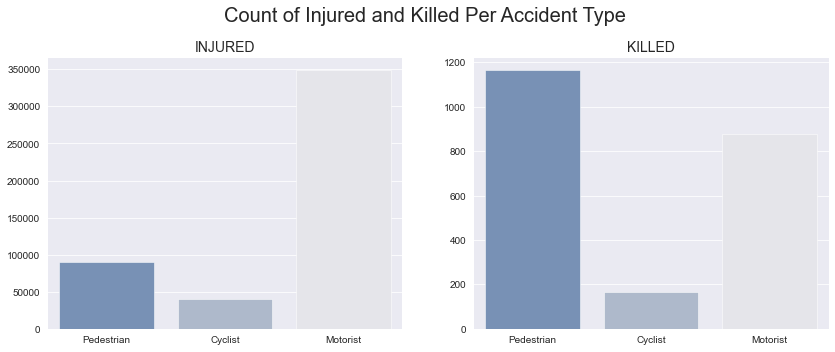

In [63]:
gr_injured = vehicle_crashes[[i for i in vehicle_crashes.columns for c in ['pedestrians_injured', 'cyclist_injured', 'motorist_injured'] if c in i]].sum()
gr_killed = vehicle_crashes[[i for i in vehicle_crashes.columns for c in ['pedestrians_killed', 'cyclist_killed', 'motorist_killed'] if c in i]].sum()

gr_injured.index = ['Pedestrian', 'Cyclist', 'Motorist']
gr_killed.index = ['Pedestrian', 'Cyclist', 'Motorist']


fig, ax = plt.subplots(1,2,figsize=(14,5))
plt.suptitle('Count of Injured and Killed Per Accident Type', fontsize=20, x=0.5,y=1.02)
ax[0].set_title('INJURED', fontsize=14)
ax[1].set_title('KILLED', fontsize=14)

sns.barplot(x=gr_injured.index, y=gr_injured.values, ax=ax[0])
sns.barplot(x=gr_killed.index, y=gr_killed.values, ax=ax[1])

In [64]:
fig = make_subplots(rows=3,cols=1,subplot_titles=('PEDESTRIAN', 'CYCLIST', 'MOTORIST'))

feat_in  = ['number_of_pedestrians_injured','number_of_cyclist_injured','number_of_motorist_injured']
feat_killed = ['number_of_pedestrians_killed','number_of_cyclist_killed', 'number_of_motorist_killed']

for i, atype in enumerate(feat_in):
    data_per_acc = vehicle_crashes.groupby('crash_date')[atype].sum()
    data_per_acc1 = vehicle_crashes.groupby('crash_date')[feat_killed[i]].sum()
    
    fig.add_trace(go.Scatter(x=data_per_acc.index, y=data_per_acc.values, name='Injured'), row=i+1,col=1)
    fig.add_trace(go.Scatter(x=data_per_acc1.index, y=data_per_acc1.values, name='Killed'), row=i+1, col=1)

fig.update_layout(title='Count of Injured and Killed Per Accident Type',template='plotly_dark', width=1000, height=1100)
fig.show()

#### Top 10 Reasons for Accidents

contributing_factor_vehicle_1
Unspecified                       630647
Driver Inattention/Distraction    337806
Failure to Yield Right-of-Way     101322
Following Too Closely              90556
Backing Unsafely                   67062
Other Vehicular                    55562
Fatigued/Drowsy                    47037
Turning Improperly                 43990
Passing or Lane Usage Improper     43705
Passing Too Closely                40202
dtype: int64


<AxesSubplot:title={'center':'CF VEHICLE 1'}, ylabel='contributing_factor_vehicle_1'>

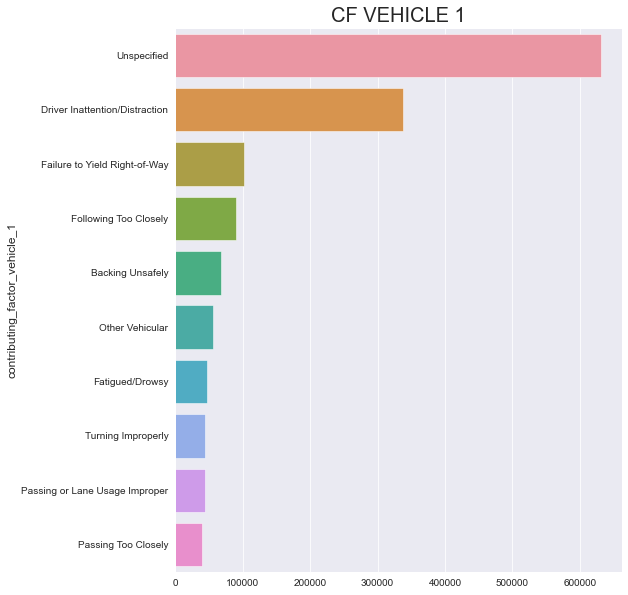

In [65]:
contri_df = vehicle_crashes.groupby('contributing_factor_vehicle_1').size().sort_values(ascending=False).head(10)
print(contri_df)
plt.figure(figsize=(8,10))
plt.title('CF VEHICLE 1', fontsize=20)

sns.barplot(y = contri_df.index, x = contri_df.values)

In [66]:
vehicle_crashes.head()

crash_date crash_time    borough zip_code   latitude  longitude  \
0 2018-10-06   23:33:00   BROOKLYN    11215  40.677937 -73.986480   
1 2018-10-24   16:25:00  MANHATTAN    10036        NaN        NaN   
2 2018-10-15   07:05:00        NaN      NaN  40.594310 -74.143190   
3 2018-10-26   16:00:00        NaN      NaN  40.756256 -73.924515   
4 2018-10-06   14:45:00   BROOKLYN    11214  40.592870 -73.996070   

                  location                    on_street_name  \
0   (40.677937, -73.98648)                               NaN   
1                      NaN  12 AVENUE                          
2    (40.59431, -74.14319)  FOREST HILL ROAD                   
3  (40.756256, -73.924515)  35 AVENUE                          
4    (40.59287, -73.99607)                               NaN   

  cross_street_name  number_of_persons_injured  ...  \
0               NaN                        0.0  ...   
1    WEST 43 STREET                        0.0  ...   
2      FIELD STREET                        0.0  ...   
3               NaN                        0.0  ...   
4               NaN                        0.0  ...   

   number_of_cyclist_injured  number_of_cyclist_killed  \
0                          0                         0   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         0   

   number_of_motorist_injured  number_of_motorist_killed  \
0                           0                          0   
1                           0                          0   
2                           0                          0   
3                           0                          0   
4                           0                          0   

    contributing_factor_vehicle_1   contributing_factor_vehicle_2  \
0  Driver Inattention/Distraction                             NaN   
1                Backing Unsafely  Passing or Lane Usage Improper   
2  Driver Inattention/Distraction  Driver Inattention/Distraction   
3  Driver Inattention/Distraction                     Unspecified   
4                Backing Unsafely                     Unspecified   

   collision_id                  vehicle_type_code_1 vehicle_type_code_2  \
0       3995534                                Sedan                 NaN   
1       4009532                                 Taxi               Sedan   
2       4000487                                Sedan               Sedan   
3       4008744  Station Wagon/Sport Utility Vehicle               Sedan   
4       3994682                                Sedan               Sedan   

             datetime  
0 2018-10-06 23:33:00  
1 2018-10-24 16:25:00  
2 2018-10-15 07:05:00  
3 2018-10-26 16:00:00  
4 2018-10-06 14:45:00  

[5 rows x 23 columns]

In [67]:
# Monthly Data
month_only = vehicle_crashes.copy() 
month_only['Date'] = month_only['datetime']
mask = month_only['Date'] > '2012-12-31' 
month_only = month_only[mask]

mask2 = month_only['Date'] < '2021-01-01' 
month_only = month_only[mask2]

# Set dates to end of the month
month_only['Year'] = month_only['Date'].map(
    lambda x: datetime.datetime(
        x.year,
        x.month,
        max(calendar.monthcalendar(x.year, x.month)[-1][:5])
    )
)

# Calculate the number of people killed, injured and total accidents for each month
month_wise = month_only.groupby(['Year'])\
['number_of_cyclist_killed', 'number_of_cyclist_injured'].agg('sum').reset_index()

month_wise['Total Accidents'] = month_only.groupby(['Year']).size().\
reset_index(name='NoOfAccidents').NoOfAccidents

# Injuries and Fatalities as Percentages
month_wise['Injury%'] = round((month_wise['number_of_cyclist_injured']/month_wise['Total Accidents'] * 100), 1)
month_wise['Fatality%'] = round((month_wise['number_of_cyclist_killed']/month_wise['Total Accidents'] * 100), 3)

month_wise = month_wise.sort_values('Total Accidents', ascending = False)

month_wise.head()

Year  number_of_cyclist_killed  number_of_cyclist_injured  \
54 2017-06-30                         6                        593   
53 2017-05-31                         1                        483   
65 2018-05-31                         1                        468   
70 2018-10-31                         0                        476   
66 2018-06-29                         2                        530   

    Total Accidents  Injury%  Fatality%  
54            21373      2.8      0.028  
53            21013      2.3      0.005  
65            20842      2.2      0.005  
70            20820      2.3      0.000  
66            20796      2.5      0.010

Text(2020-06-25, 10000, '2020')

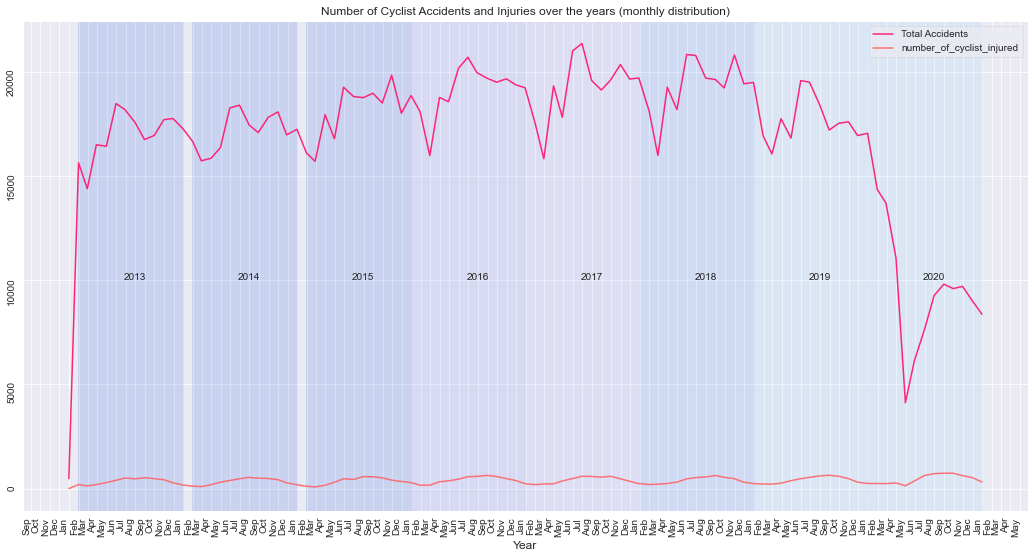

In [68]:
# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(18, 10))

# Defining color map
color = np.flip(cm.Oranges(np.linspace(.2,.6, 10)))
color2 = np.flip(cm.plasma(np.linspace(.2,.6, 10)))

# Creating the plot
month_wise.plot(x = 'Year', y = 'Total Accidents', kind = 'line', 
                color = color, stacked = True, ax = ax)
month_wise.plot(x = 'Year', y = 'number_of_cyclist_injured', kind = 'line', 
                color = color2, stacked = True, ax = ax)

# Customizing the Visulation
ax.set_title('Number of Cyclist Accidents and Injuries over the years (monthly distribution)', size = 12)
ax.set_xlabel('Year', size = 12)
ax.tick_params(labelrotation = 90)

# Set the locator
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')

x_axis = plt.gca().xaxis
x_axis.set_major_locator(locator)

# Specify formatter
x_axis.set_major_formatter(fmt)

plt.axvspan('2013-01-30', '2013-12-31', alpha = 0.14, color = 'xkcd:blue')
plt.text('2013-06-25', 10000, '2013')

plt.axvspan('2014-01-30', '2014-12-31', alpha = 0.14, color = 'xkcd:blue')
plt.text('2014-06-25', 10000, '2014')

plt.axvspan('2015-01-30', '2015-12-31', alpha = 0.14, color = 'xkcd:blue')
plt.text('2015-06-25', 10000, '2015')

plt.axvspan('2016-01-01', '2016-12-31', alpha = 0.14, color = 'xkcd:cornflower')
plt.text('2016-06-25', 10000, '2016')

plt.axvspan('2017-01-01', '2017-12-31', alpha = 0.14, color = 'xkcd:periwinkle blue')
plt.text('2017-06-25', 10000, '2017')

plt.axvspan('2018-01-01', '2018-12-31', alpha = 0.14, color = 'xkcd:lightish blue')
plt.text('2018-06-25', 10000, '2018')

plt.axvspan('2019-01-01', '2019-12-31', alpha = 0.14, color = 'xkcd:sky')
plt.text('2019-06-25', 10000, '2019')

plt.axvspan('2020-01-01', '2020-12-31', alpha = 0.14, color = 'xkcd:sky')
plt.text('2020-06-25', 10000, '2020')


In [69]:
#create dataframe of latitude and longitude
weekwise2 = weekwise[['crash_date','latitude','longitude','number_of_cyclist_injured','number_of_cyclist_killed']].dropna(how='any')
weekwise2 = weekwise2[pd.DatetimeIndex(weekwise2.crash_date).year > 2012]
weekwise2 = weekwise2.loc[weekwise2['number_of_cyclist_injured'] > 0]
weekwise2.shape

(34723, 5)

In [70]:
#Access token from Plotly
mapbox_style = 'mapbox://styles/teeradol/cjvvz389101a81co5hqfdbvsi'
mapbox_access_token = 'pk.eyJ1Ijoia3Jwb3BraW4iLCJhIjoiY2pzcXN1eDBuMGZrNjQ5cnp1bzViZWJidiJ9.ReBalb28P1FCTWhmYBnCtA'

#Prepare data for Plotly
data = [
    go.Scattermapbox(
        lat=weekwise2.latitude,
        lon=weekwise2.longitude,
        mode='markers',
        text=weekwise2['number_of_cyclist_injured'],
        marker=dict(
            size=7,
            color=weekwise2['number_of_cyclist_injured'],
            #colorscale='RdBu',
            #reversescale=True,
            colorbar=dict(title='Injured'
            )
        ),
    )
]

#Prepare layout for Plotly
layout = go.Layout(
    autosize=True,
    hovermode='closest',
    title='NYPD Cyclist Borough Wise Collisions',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=40.721319,
            lon=-73.987130
        ),
        pitch=2,
        zoom=8,
        style=mapbox_style
    ),
    xaxis = dict(domain = [0.6, 1])
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='NYPD Collisions')

In [71]:
#create dataframe of latitude and longitude
weekwise_manhattan = weekwise.loc[weekwise['borough'] == "MANHATTAN"]
weekwise3 = weekwise_manhattan[['crash_date','latitude','longitude','number_of_cyclist_injured','number_of_cyclist_killed']].dropna(how='any')
weekwise3 = weekwise3[pd.DatetimeIndex(weekwise3.crash_date).year > 2012]
weekwise3 = weekwise3.loc[weekwise3['number_of_cyclist_injured'] > 0]
weekwise3.shape

(8352, 5)

# EDA of Bike Stations

In [72]:
bike_stations = pd.read_json('https://feeds.citibikenyc.com/stations/stations.json')
bike_stations= bike_stations.drop(columns=['executionTime'],axis=1)
bike_stations=bike_stations.stationBeanList.apply(pd.Series)
bike_stations.shape

(509, 18)

In [73]:
#Fill the ZIP code from the Latitude and Longitude data 
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)
from uszipcode import Zipcode

def get_zipcode(lat, lon):
    result = search.by_coordinates(lat = lat, lng = lon, returns = 1)
    #print(result[0].zipcode)
    return result[0].zipcode

bike_stations['Zip'] = bike_stations.apply(lambda x: get_zipcode(x.latitude,x.longitude), axis=1)

In [74]:
bike_stations.info() #All the missing Zip Codes are filled

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     509 non-null    int64  
 1   stationName            509 non-null    object 
 2   availableDocks         509 non-null    int64  
 3   totalDocks             509 non-null    int64  
 4   latitude               509 non-null    float64
 5   longitude              509 non-null    float64
 6   statusValue            509 non-null    object 
 7   statusKey              509 non-null    int64  
 8   availableBikes         509 non-null    int64  
 9   stAddress1             509 non-null    object 
 10  stAddress2             509 non-null    object 
 11  city                   509 non-null    object 
 12  postalCode             509 non-null    object 
 13  location               509 non-null    object 
 14  altitude               509 non-null    object 
 15  testSt

In [75]:
bike_stations['Zip'] = bike_stations['Zip'].astype('int64')

In [76]:
bike_stations=pd.merge(bike_stations, zipcode_bor, how='left',on='Zip')

In [77]:
#search.by_zipcode(7302)

In [78]:
#Filtering Bike Locations for Manhattan
bike_manhattan = bike_stations.loc[bike_stations['Borough']=='Manhattan']
bike3 = bike_manhattan[['latitude','longitude','id']].dropna(how='any')
bike3 = bike3.loc[bike3['id'] > 0]

# Collision analysis For Manhattan Borough

In [79]:
#Access token from Plotly
mapbox_access_token = 'pk.eyJ1Ijoia3Jwb3BraW4iLCJhIjoiY2pzcXN1eDBuMGZrNjQ5cnp1bzViZWJidiJ9.ReBalb28P1FCTWhmYBnCtA'

#Prepare data for Plotly
data = [
    go.Scattermapbox(
        lat=bike3.latitude,
        lon=bike3.longitude,
        mode='markers',
        text=bike3['id'],
        marker=dict(
            size=7,
            #color=bike3['id'],
            #colorscale='bu',
            reversescale=True,
           
        ),
    )
]

#Prepare layout for Plotly
layout = go.Layout(
    autosize=True,
    hovermode='closest',
    title='Bike Station Locations in Manhattan',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=40.721319,
            lon=-73.987130
        ),
        pitch=2,
        zoom=8,
        style=mapbox_style
    ),
    xaxis = dict(domain = [0.6, 1])
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='NYPD Collisions')

# 2. What would you change in the locations of bike stations to increase safety? Use visualization. 

###  Move all the Bike Stations which are in close proximity to the Collision site (Manhattan) 

In [80]:
#Access token from Plotly
mapbox_style = 'mapbox://styles/teeradol/cjvvz389101a81co5hqfdbvsi'
mapbox_access_token = 'pk.eyJ1Ijoia3Jwb3BraW4iLCJhIjoiY2pzcXN1eDBuMGZrNjQ5cnp1bzViZWJidiJ9.ReBalb28P1FCTWhmYBnCtA'

#Prepare data for Plotly
data = [
    go.Scattermapbox(
        lat=weekwise3.latitude,
        lon=weekwise3.longitude,
        mode='markers',
        text=weekwise3['number_of_cyclist_injured'],
        marker=dict(
            size=7,
            color='rgba(255, 0, 0, 1)',
            #color=weekwise3['number_of_persons_injured'],
            #colorscale='Rd',
            #Reversescale=True,
            colorbar=dict(
                title='Injured')
            )
        ),
           go.Scattermapbox(
        lat=bike3.latitude,
        lon=bike3.longitude,
        mode='markers',
        text=bike3['id'],
        marker=dict(
        size=7,
        #color=bike3['id'],
        #colorscale='bu',
        color='rgba(255, 255, 0, 1)'
        #reversescale=True,
           
        )
    ),
]
    

#Prepare layout for Plotly
layout = go.Layout(
    autosize=True,
    hovermode='closest',
    title='Manhattan Cyclist Collisions and Location of the Bike Stations ',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=40.721319,
            lon=-73.987130
        ),
        pitch=2,
        zoom=8,
        style=mapbox_style
    ),
    xaxis = dict(domain = [0.6, 1])
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='NYPD Collisions')
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

In [81]:
#Creating Tuple of the Latitude and Longitude 
weekwise3['lat_long'] = weekwise3[['latitude', 'longitude']].apply(tuple, axis=1)
bike3['lat_long']=bike3[['latitude', 'longitude']].apply(tuple, axis=1)

### Calculating the Distance between each Bike station and Collision Loction in meters

In [89]:
result = [] 
for i in weekwise3['lat_long']:
            for j in bike3['lat_long']:
                result.append([i,j]) 
Distance_bike_collision=pd.DataFrame(result, columns=['Injury Location','Bike Location'])

In [91]:
# Calculating the Distance in meters
distance = []
for i in weekwise3['lat_long']:
            for j in bike3['lat_long']:
                distance.append(round(geodesic(i,j).m,2))

In [92]:
Distance_bike_collision['Distance']= distance

In [93]:
tesdf = Distance_bike_collision.loc[Distance_bike_collision['Distance'] <15]

In [95]:
tesdf['Bike Location'].unique()

array([(40.74290902, -73.97706058), (40.7451677, -73.98683077),
       (40.70955958, -74.00653609), (40.711512, -74.015756),
       (40.73226398, -73.99852205), (40.72938685, -73.97772429),
       (40.748238, -73.978311), (40.76068327096592, -73.9845272898674),
       (40.746647, -73.993915), (40.75898481399634, -73.99379968643188),
       (40.7423543, -73.98915076), (40.7770575, -73.97898475),
       (40.7284186, -73.98713956), (40.727791260000004, -73.98564945),
       (40.72043411, -74.01020609),
       (40.758996559605116, -73.96865397691727),
       (40.74854862, -73.98808416),
       (40.733812191966315, -73.98054420948029),
       (40.72165481, -74.00234737),
       (40.77579376683666, -73.9762057363987), (40.771522, -73.990541),
       (40.73535398, -74.00483091),
       (40.73997354103409, -74.00513872504234), (40.735238, -74.000271),
       (40.73704984, -73.99009296), (40.75299641, -73.98721619),
       (40.728846, -74.008591), (40.74901271, -73.98848395),
       (40.7162500

### There are over 18 Bike Stations in close proximity (15 metes and less) to the collision location. Hence to increase the safety we can relocate these 18 bike stations away from the Collision Locations.  

## 3. Create a predictive model
### (Predictions for Manahttan Borough)

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
plt.style.use('ggplot')
import warnings
import itertools
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [131]:
data = weekwise.loc[weekwise['borough'] == 'MANHATTAN']
data = data.fillna("0")

In [132]:
data1 = pd.DataFrame(data.groupby(['crash_date'])['number_of_cyclist_injured'].sum()).reset_index()

In [133]:
data1['crash_date'] = pd.to_datetime(data1['crash_date'])
data1 = data1.sort_values(by=['crash_date'])

In [134]:
accident = data1.set_index('crash_date')
accident.index

DatetimeIndex(['2012-07-01', '2012-07-02', '2012-07-03', '2012-07-04',
               '2012-07-05', '2012-07-06', '2012-07-07', '2012-07-08',
               '2012-07-09', '2012-07-10',
               ...
               '2021-02-25', '2021-02-26', '2021-02-27', '2021-02-28',
               '2021-03-01', '2021-03-02', '2021-03-03', '2021-03-04',
               '2021-03-05', '2021-03-06'],
              dtype='datetime64[ns]', name='crash_date', length=3171, freq=None)

In [135]:
accident
### Testing For Stationarity
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(accident['number_of_cyclist_injured'])

In [136]:
#Ho: It is non stationary
#H1: It is stationary
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [137]:
adfuller_test(accident['number_of_cyclist_injured'])
# P values is less than 0.05 or 5% hence the data is stationary

ADF Test Statistic : -4.170960316749795
p-value : 0.0007375815373834396
#Lags Used : 27
Number of Observations Used : 3143
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


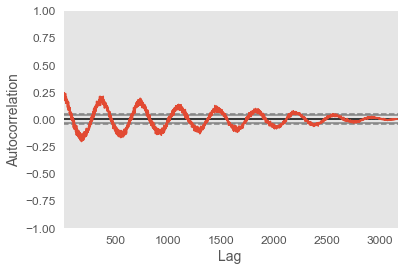

In [138]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(accident['number_of_cyclist_injured'])
plt.show()

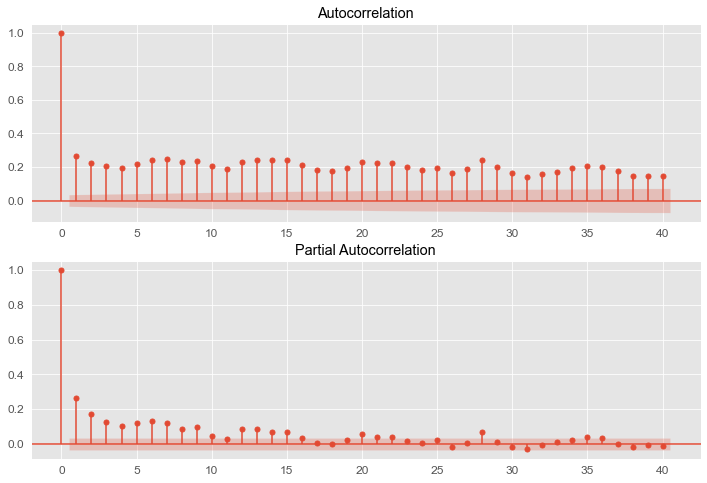

In [139]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(accident['number_of_cyclist_injured'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(accident['number_of_cyclist_injured'].iloc[13:],lags=40,ax=ax2)

In [140]:
y = accident['number_of_cyclist_injured'].resample('MS').mean() #month start frequency
y.head()

crash_date
2012-07-01    3.645161
2012-08-01    4.032258
2012-09-01    3.500000
2012-10-01    2.741935
2012-11-01    2.266667
Freq: MS, Name: number_of_cyclist_injured, dtype: float64

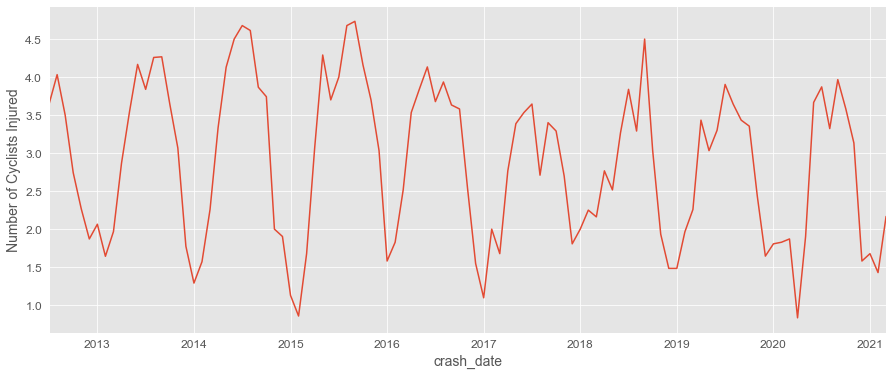

In [141]:
y.plot(figsize=(15, 6))
plt.ylabel('Number of Cyclists Injured')
plt.show()

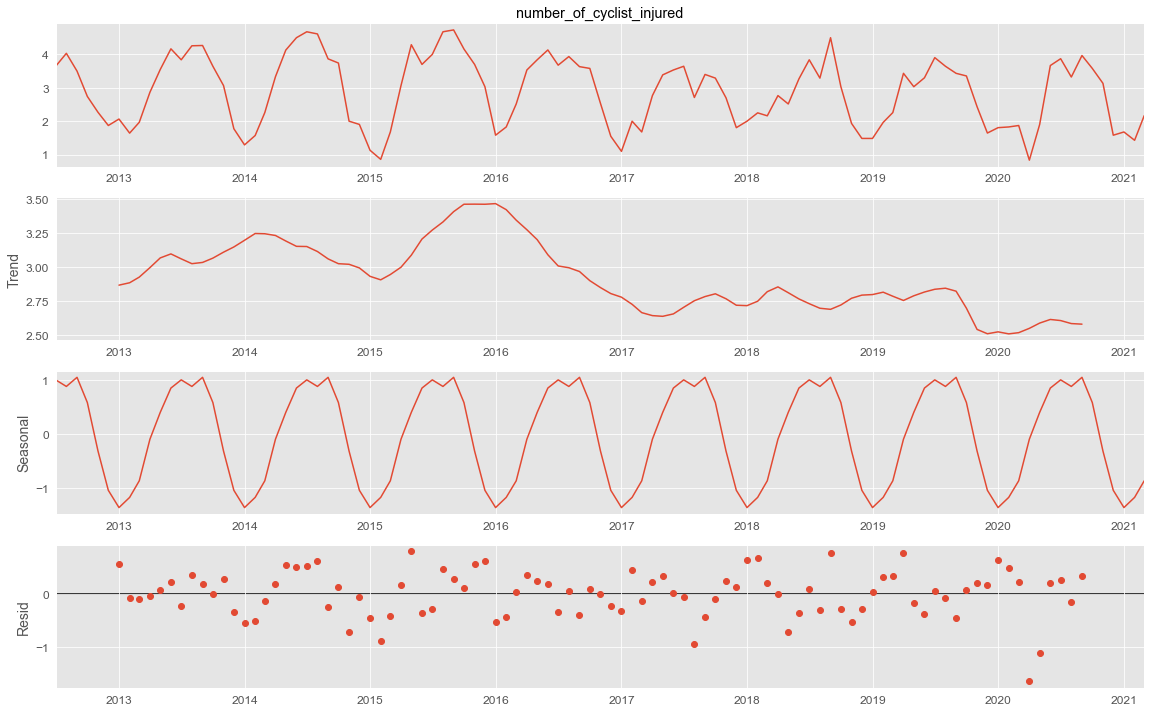

<Figure size 1152x720 with 0 Axes>

In [142]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 16, 10
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()
plt.tight_layout()

In [143]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [146]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:529.9124131948586
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:392.3454417316688
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:189.8403833832975
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:146.65329534454935
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:191.09738862844424
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:163.4261019272472
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:150.35696832754937
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:147.3547193112742
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:410.6898767123992
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:309.1474187581864
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:170.85730687186884
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:132.02614386531877
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:172.6650324744507
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:146.94952474688276
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:138.29724274857176
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:133.38755862352576
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:221.04615811623535
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:188.54556714884706


C:\Users\136247\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:216.1441459874148
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:188.8444854053489
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:180.86322606881845
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:139.96644251169354
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:174.56838979162083
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:156.4292500596021
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:146.84357920040708
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:141.43507995747765
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:222.6259008530613
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:189.8923746937158
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:167.90840388907432
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:129.36854453991646
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:166.67599276396197
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:144.15848243927323
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:132.74230991349472
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:131.12321336067072
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:217.3217370954291
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:189.3601206404075

In [147]:
#ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:138.7012539680286
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4348      0.144      3.018      0.003       0.152       0.717
ma.L1         -1.0000    137.341     -0.007      0.994    -270.184     268.184
ar.S.L12      -0.5195      0.117     -4.449      0.000      -0.748      -0.291
sigma2         0.2942     40.432      0.007      0.994     -78.951      79.540


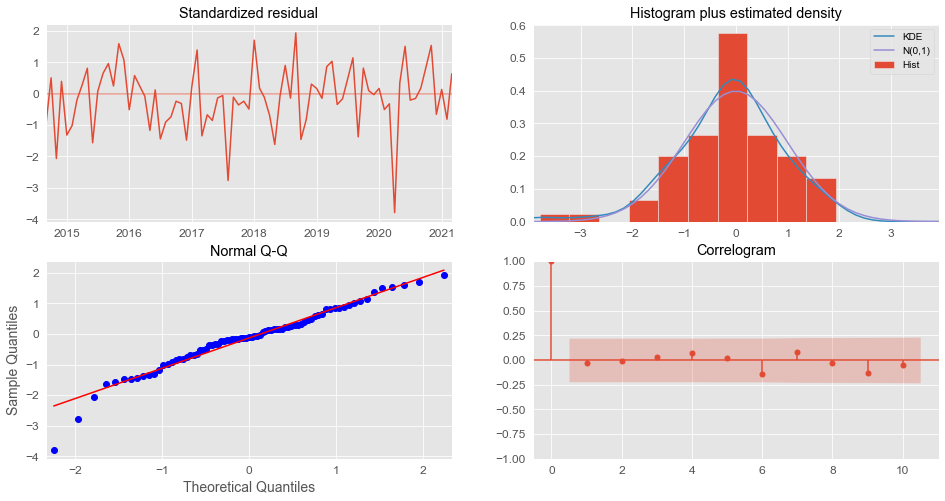

In [148]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

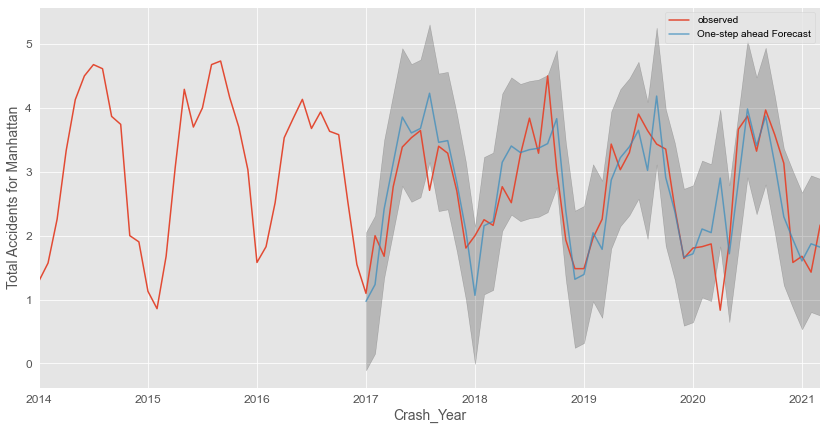

In [149]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Crash_Year')
ax.set_ylabel('Total Accidents for Manhattan')
plt.legend()
plt.show()

In [150]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#Very Good MSE Value

The Mean Squared Error of our forecasts is 0.32


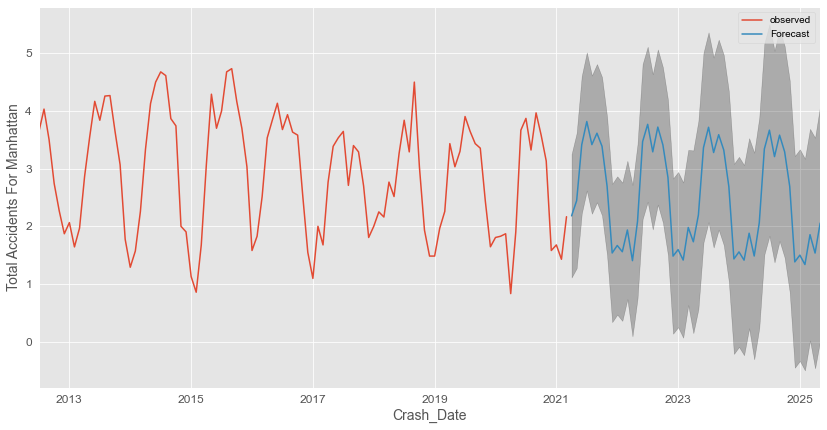

In [151]:
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Crash_Date')
ax.set_ylabel('Total Accidents For Manhattan')
plt.legend()
plt.show()    